<a href="https://colab.research.google.com/github/Neermita18/SystemsBiology/blob/main/SolubilityWithGCNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [115]:
pip install deepchem

In [116]:
pip install torch torchvision torch-geometric rdkit

In [117]:
from torch_geometric.data import DataLoader
from torch_geometric.datasets import MoleculeNet
from torch_geometric.nn import GCNConv, global_mean_pool
from rdkit import Chem
from rdkit.Chem import AllChem
import torch
import torch.nn as nn
import torch.optim as optim
from rdkit.Chem import AllChem, Draw
import deepchem as dc
import pandas as pd
import numpy as np
dataset = MoleculeNet(root='data/Freesolv', name='FreeSolv')

### Analysing the Dataset

In [118]:
dataset.data

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Data(x=[5600, 9], edge_index=[2, 10770], edge_attr=[10770, 3], y=[642, 1], smiles=[642])

In [119]:
dataset.data.x

tensor([[6, 0, 4,  ..., 4, 0, 0],
        [7, 0, 3,  ..., 3, 0, 0],
        [6, 0, 4,  ..., 4, 0, 0],
        ...,
        [6, 0, 4,  ..., 4, 0, 1],
        [6, 0, 4,  ..., 4, 0, 1],
        [8, 0, 2,  ..., 4, 0, 1]])

In [120]:
dataset.data.edge_index.shape

torch.Size([2, 10770])

In [121]:
dataset.data.edge_attr.shape

torch.Size([10770, 3])

In [122]:
x=dataset[0].smiles

In [123]:

mols= Chem.MolFromSmiles(x)

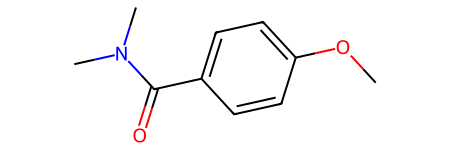

In [124]:
mols

In [125]:
feat=dc.feat.RDKitDescriptors()

In [126]:
data = pd.read_csv("/content/SAMPL_df_revised.csv")

In [127]:
data

,iupac,smiles,expt,calc
0,"4-methoxy-N,N-dimethyl-benzamide",CN(C)C(=O)c1ccc(cc1)OC,-11.01,-9.625
1,methanesulfonyl chloride,CS(=O)(=O)Cl,-4.87,-6.219
2,3-methylbut-1-ene,CC(C)C=C,1.83,2.452
3,2-ethylpyrazine,CCc1cnccn1,-5.45,-5.809
4,heptan-1-ol,CCCCCCCO,-4.21,-2.917
...,...,...,...,...
637,methyl octanoate,CCCCCCCC(=O)OC,-2.04,-3.035
638,pyrrolidine,C1CCNC1,-5.48,-4.278
639,4-hydroxybenzaldehyde,c1cc(ccc1C=O)O,-8.83,-10.050
640,1-chloroheptane,CCCCCCCCl,0.29,1.467


In [128]:
dataset[0].y

tensor([[-11.0100]])

In [129]:
edge_weight = dataset.data.edge_attr.sum(dim=1)

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [130]:
dataset.data.edge_attr

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


tensor([[1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        ...,
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]])

In [131]:
print(dataset.data.edge_index)

tensor([[0, 1, 1,  ..., 4, 5, 5],
        [1, 0, 2,  ..., 5, 0, 4]])


In [132]:
unique_attrs = torch.unique(dataset.data.edge_attr, dim=0)
print("Unique edge attribute patterns:", unique_attrs)

Unique edge attribute patterns: tensor([[ 1,  0,  0],
        [ 1,  0,  1],
        [ 2,  0,  0],
        [ 2,  0,  1],
        [ 2,  2,  0],
        [ 2,  2,  1],
        [ 2,  3,  0],
        [ 2,  3,  1],
        [ 3,  0,  0],
        [ 3,  0,  1],
        [12,  0,  1]])


In [133]:
from torch_geometric.utils import to_dense_adj

# edge_index: (2, E), edge_weight: (E,)
adj = to_dense_adj(dataset.data.edge_index, edge_attr=edge_weight)  # Shape: (1, N, N)


In [134]:
adj=adj.squeeze(0)

In [135]:
adj.shape

torch.Size([24, 24])

So, the target values are the experimental hydration energies

### Model Creation

In [136]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import global_add_pool

In [137]:
class MPNN(nn.Module):
  def __init__(self, node_dim, edge_dim=None, hidden_dim=64):
    super(MPNN, self).__init__()
    self.node=node_dim
    self.edge=edge_dim
    self.hidden=hidden_dim
    self.lin0= nn.Linear(in_features=node_dim, out_features=hidden_dim)
    self.conv1= GCNConv(in_channels=hidden_dim, out_channels=hidden_dim)
    self.conv2= GCNConv(in_channels=hidden_dim, out_channels=hidden_dim)

    # Feature update layer
    self.feature_update= nn.Linear(in_features=2*hidden_dim, out_features=hidden_dim)

  def forward(self, node_attr,edge_index):
    node_attr= node_attr.float()
    x=self.lin0(node_attr)
    x1=F.relu(self.conv1(x, edge_index))
    x2=F.relu(self.conv2(x1, edge_index))
    x=self.feature_update(torch.cat([x, x2], dim=1))
    return x



In [138]:
class SoluGCN(nn.Module):
  def __init__(self, node_dim, edge_weight, edge_dim=None, hidden_dim=64):
    super(SoluGCN, self).__init__()
    self.node=node_dim
    self.edge=edge_dim
    self.hidden=hidden_dim
    self.edge_weight=edge_weight
    self.mpnn = MPNN(node_dim, edge_dim, hidden_dim)
    self.lin1=nn.Linear(in_features=hidden_dim, out_features=128)
    self.lin2=nn.Linear(in_features=128, out_features=64)
    self.lin3=nn.Linear(in_features=64, out_features=1)
    self.pool = global_add_pool

  def forward(self, dataset):
    x, edge_index, batch = dataset.x, dataset.edge_index, dataset.batch
    x=self.mpnn(x, edge_index)
    x=self.pool(x, batch)
    x=F.relu(self.lin1(x))
    x=F.relu(self.lin2(x))
    x=self.lin3(x)
    return x



In [139]:
dataset.data

Data(x=[5600, 9], edge_index=[2, 10770], edge_attr=[10770, 3], y=[642, 1], smiles=[642])

In [140]:
train_dataset= dataset[:int(0.8 * len(dataset))]
val_dataset= dataset[int(0.8 * len(dataset)):int(0.9 * len(dataset))]
test_dataset= dataset[int(0.9 * len(dataset)):]

In [141]:

train_dataset

FreeSolv(513)

In [142]:
test_dataset[0]

Data(x=[9, 9], edge_index=[2, 18], edge_attr=[18, 3], smiles='Cc1ccc(cc1C)O', y=[1, 1])

In [143]:
train_dataset[0]

Data(x=[13, 9], edge_index=[2, 26], edge_attr=[26, 3], smiles='CN(C)C(=O)c1ccc(cc1)OC', y=[1, 1])

In [144]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [145]:
dataset.edge_index.shape

torch.Size([2, 10770])

In [146]:
for batch in train_loader:
  new=batch
  break

In [147]:
print(f"data: {new.x.shape}")
print(f"edge index: {new.edge_index.shape}")
print(f"edge attr: {new.edge_attr.shape}")
print(f"target: {new.y.shape}")

data: torch.Size([290, 9])
edge index: torch.Size([2, 556])
edge attr: torch.Size([556, 3])
target: torch.Size([32, 1])


In [148]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [149]:
model = SoluGCN(node_dim=dataset.num_node_features,edge_weight=edge_weight, hidden_dim=64).to(device)

In [150]:
model

SoluGCN(
  (mpnn): MPNN(
    (lin0): Linear(in_features=9, out_features=64, bias=True)
    (conv1): GCNConv(64, 64)
    (conv2): GCNConv(64, 64)
    (feature_update): Linear(in_features=128, out_features=64, bias=True)
  )
  (lin1): Linear(in_features=64, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=64, bias=True)
  (lin3): Linear(in_features=64, out_features=1, bias=True)
)

### Training

In [167]:
def train(model, loader, optimizer, criterion, device):
  model.train()
  total_loss = 0
  for data in loader:
      data = data.to(device)
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, data.y.view(-1, 1))
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
  return total_loss / len(loader)

In [168]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training loop
epochs = 1000
for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    # val_loss = evaluate(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}")

Epoch 1/1000, Train Loss: 3.9574
Epoch 2/1000, Train Loss: 3.8594
Epoch 3/1000, Train Loss: 3.1125
Epoch 4/1000, Train Loss: 3.2569
Epoch 5/1000, Train Loss: 3.0053
Epoch 6/1000, Train Loss: 3.3826
Epoch 7/1000, Train Loss: 3.4605
Epoch 8/1000, Train Loss: 4.7069
Epoch 9/1000, Train Loss: 4.9647
Epoch 10/1000, Train Loss: 3.3996
Epoch 11/1000, Train Loss: 2.9752
Epoch 12/1000, Train Loss: 2.9986
Epoch 13/1000, Train Loss: 4.0986
Epoch 14/1000, Train Loss: 3.4298
Epoch 15/1000, Train Loss: 3.8453
Epoch 16/1000, Train Loss: 3.8913
Epoch 17/1000, Train Loss: 3.9345
Epoch 18/1000, Train Loss: 9.5472
Epoch 19/1000, Train Loss: 7.0894
Epoch 20/1000, Train Loss: 6.3561
Epoch 21/1000, Train Loss: 5.6212
Epoch 22/1000, Train Loss: 5.1320
Epoch 23/1000, Train Loss: 4.6305
Epoch 24/1000, Train Loss: 4.0073
Epoch 25/1000, Train Loss: 3.6323
Epoch 26/1000, Train Loss: 3.4520
Epoch 27/1000, Train Loss: 3.4834
Epoch 28/1000, Train Loss: 3.8000
Epoch 29/1000, Train Loss: 4.9077
Epoch 30/1000, Train Lo

### Test one molecule

In [169]:
single_molecule = test_dataset[np.random.randint(0, len(test_dataset))]

single_molecule = single_molecule.to(device)

In [170]:
model.eval()
with torch.no_grad():
    prediction = model(single_molecule)
    print(f"Predicted hydration energy: {prediction.item()}")

Predicted hydration energy: 2.329380989074707


In [171]:
single_molecule.y

tensor([[2.5100]])

In [172]:
mol=Chem.MolFromSmiles(single_molecule.smiles)

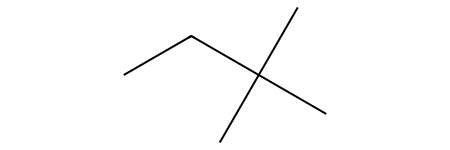

In [173]:
mol

### Testing

In [174]:
def testing(data):
  model.eval()
  total_loss = 0
  with torch.no_grad():
    for data in test_loader:
      data = data.to(device)
      output = model(data)
      loss = criterion(output, data.y.view(-1, 1))
      total_loss += loss.item()
  return total_loss / len(test_loader)

In [175]:
print(f"Test Loss: {testing(test_loader):.4f}")

Test Loss: 2.4302
